In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json

|## Loading data

In [2]:
norms = pd.read_csv('../../data/psychNorms/psychNorms.zip', index_col=0, low_memory=False)
rca_full = pd.read_csv('../../data/results/rca.csv')
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col='norm')

print(f"# Norms: {len(meta.index.unique())}")
print(f"# Norm categories: {len(meta['category'].unique())}")
print(f"# Embeds: {len(rca_full['embed'].unique())}")

# Adding norm category
rca_full['norm_category'] = (
    rca_full['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca_full

# Norms: 292
# Norm categories: 27
# Embeds: 24


,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7003,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7004,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7005,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7006,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


## Evaluating how many embed-norm pairs didn't pass the checker

In [3]:
rca_full['check'].value_counts()

pass                                    6249
test_n < 20                              722
too few classes (of sufficient size)      23
associated_embed                          14
Name: check, dtype: int64

In [4]:
def groupby_pivot(df):
    return(
        df.groupby(['embed', 'norm_category'], as_index=False).count()
        .pivot(index='embed', columns='norm_category', values='norm')
    )

rca = rca_full.dropna()
rca_full_counts = groupby_pivot(rca_full[['embed', 'norm_category', 'norm']])
rca_counts =  groupby_pivot(rca[['embed', 'norm_category', 'norm']])

rca_full_counts, rca_counts = rca_full_counts.align(rca_counts, join='outer')
perc_retained = ((rca_counts / rca_full_counts) * 100)
perc_retained

norm_category,age of acquisition,animacy,arousal,associatability,autidtory lexical decision,concreteness,dominance,emotion,familiarity,frequency,...,recognition memory,semantic decision,semantic diversity,semantic neighborhood,sensory,social/moral,space/time/quantity,this/that,valence,visual lexical decision
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
EEG_speech,75.00,100.000000,77.777778,33.333333,100.0,100.000000,100.0,77.419355,31.818182,100.0,...,100.0,70.0,72.727273,100.000000,72.222222,62.50,96.0,100.0,66.666667,100.0
EEG_text,81.25,100.000000,88.888889,33.333333,100.0,100.000000,100.0,80.645161,59.090909,100.0,...,100.0,90.0,72.727273,100.000000,77.777778,87.50,100.0,100.0,77.777778,100.0
GloVe_CommonCrawl,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
GloVe_Twitter,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
GloVe_Wikipedia,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
LexVec_CommonCrawl,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
PPMI_SVD_EAT,93.75,100.000000,100.000000,66.666667,100.0,100.000000,100.0,100.000000,95.454545,100.0,...,100.0,90.0,100.000000,100.000000,94.444444,100.00,100.0,100.0,100.000000,100.0
PPMI_SVD_SWOW,100.00,100.000000,100.000000,66.666667,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,90.0,100.000000,85.714286,100.000000,100.00,100.0,100.0,100.000000,100.0


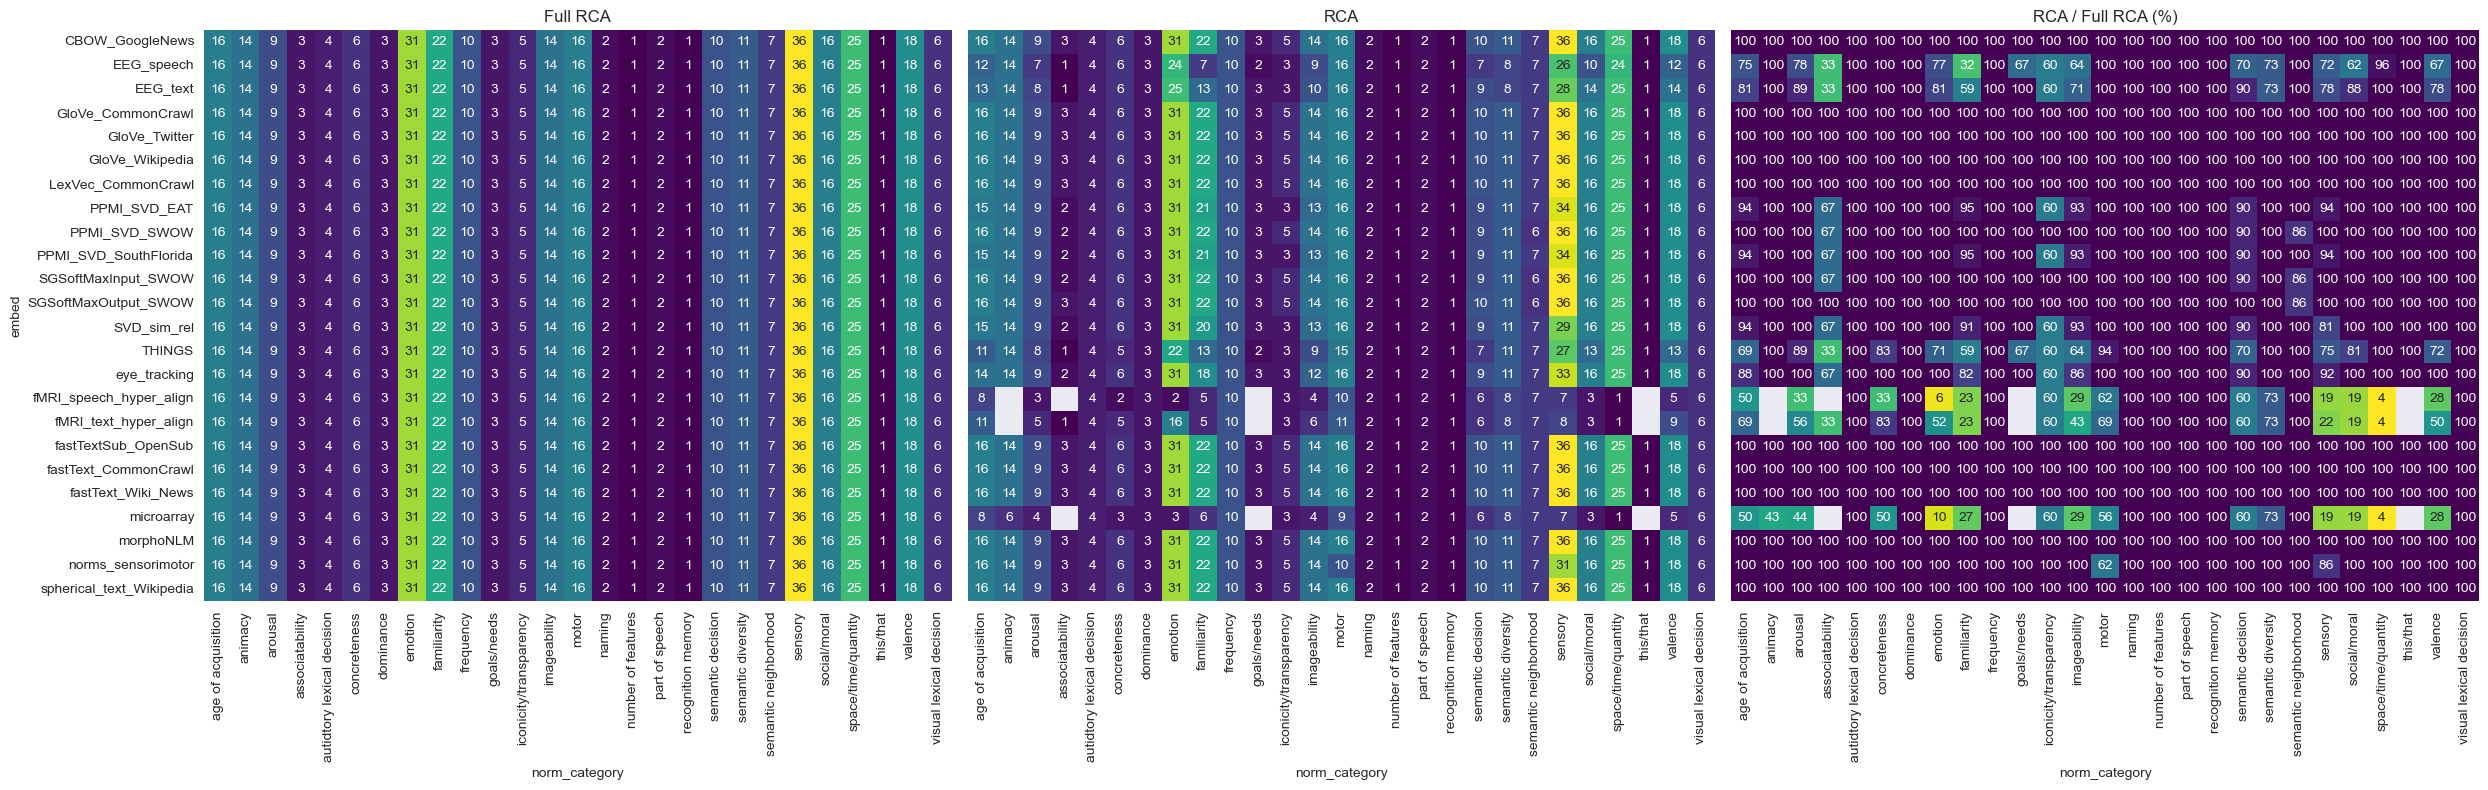

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))

sns.heatmap(rca_full_counts, ax=axs[0], cmap='viridis', annot=True, fmt='g', cbar=False)

sns.heatmap(rca_counts, ax=axs[1], cmap='viridis', annot=True, fmt='g', cbar=False)

sns.heatmap(-perc_retained, ax=axs[2], cmap='viridis', annot=perc_retained.round(0), fmt='g', cbar=False)

axs[0].set_title('Full RCA')
axs[1].set_title('RCA')
axs[2].set_title('RCA / Full RCA (%)')

# remove y tick labels for all but the first plot
for ax in axs[1:]:
    ax.set(ylabel='')
    ax.set_yticklabels([])
    
fig.tight_layout()

# Results stats

In [6]:
# Stats reported in the paper
def avg_r2(embed, norm_category):
    avg_r2 = rca.query(f"embed == '{embed}' & norm_category == '{norm_category}'")['r2_mean'].median()
    print(f'{embed} {norm_category} avg r2: {round(avg_r2, 2)}')

# Mean r2s
avg_r2('CBOW_GoogleNews', 'part of speech')
avg_r2('CBOW_GoogleNews', 'animacy')
avg_r2('CBOW_GoogleNews', 'concreteness')

CBOW_GoogleNews part of speech avg r2: 0.66
CBOW_GoogleNews animacy avg r2: 0.71
CBOW_GoogleNews concreteness avg r2: 0.7


In [7]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
rca['embed_type'] = rca['embed'].map(embed_to_type)
rca

/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_31621/1374170505.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rca['embed_type'] = rca['embed'].map(embed_to_type)


,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7003,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7004,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7005,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7006,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


In [8]:
# rca average
rca_avg = (
    rca[['norm_category', 'embed', 'r2_mean']]
    .groupby(['norm_category', 'embed'], as_index=False).median()
)

rca_avg = rca_avg.pivot(index='embed', columns='norm_category', values='r2_mean')
rca_avg

norm_category,age of acquisition,animacy,arousal,associatability,autidtory lexical decision,concreteness,dominance,emotion,familiarity,frequency,...,recognition memory,semantic decision,semantic diversity,semantic neighborhood,sensory,social/moral,space/time/quantity,this/that,valence,visual lexical decision
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,0.528642,0.708571,0.540332,0.250237,0.160777,0.704512,0.498838,0.521944,0.316924,0.530482,...,0.374071,0.124299,0.528248,0.182791,0.590522,0.639605,0.517847,0.559614,0.643696,0.365517
EEG_speech,-0.144143,-0.062606,-0.049592,-0.021250,-0.011122,-0.076180,-0.009880,-0.102030,-0.009213,-0.221704,...,-0.007643,-0.150650,-0.174743,-0.055312,-0.061014,-0.081447,-0.069191,-0.089141,-0.031951,-0.025405
EEG_text,-0.023821,-0.186480,-0.038429,-0.038361,-0.003230,-0.078904,-0.006034,-0.019019,-0.039066,-0.077158,...,-0.025770,-0.028552,-0.053622,-0.015566,-0.083851,-0.049937,-0.063821,-0.142636,-0.020548,-0.012066
GloVe_CommonCrawl,0.402780,0.676408,0.501339,-0.082646,0.048212,0.683420,0.499238,0.482844,-0.049689,-0.074540,...,0.253358,-0.012816,-0.012600,0.027508,0.552368,0.661483,0.434405,0.433699,0.639887,0.081308
GloVe_Twitter,0.255263,0.586769,0.428176,-0.044025,-0.005276,0.567716,0.364736,0.358111,0.064170,0.438174,...,0.314946,-0.006467,0.348392,0.047796,0.422093,0.537661,0.378346,0.422850,0.548663,0.129708
GloVe_Wikipedia,0.375740,0.604395,0.361869,0.117255,0.000060,0.574582,0.385444,0.409698,0.065488,0.508448,...,0.240284,-0.003365,0.299916,0.005656,0.422325,0.526845,0.373908,0.422045,0.514625,0.089133
LexVec_CommonCrawl,0.170679,0.696819,0.500268,-0.070276,0.052320,0.678555,0.443872,0.519173,-0.020474,-0.319860,...,0.286514,-0.017134,-0.037393,-0.218411,0.552567,0.626962,0.470007,0.464478,0.606405,0.040040
PPMI_SVD_EAT,0.141246,0.483129,0.370192,0.109449,0.017864,0.540804,0.442227,0.368988,0.082504,0.389365,...,0.286561,0.045969,0.353953,0.164263,0.474391,0.435829,0.310937,0.323163,0.457198,0.186248
PPMI_SVD_SWOW,0.216044,0.606707,0.618196,0.207612,0.018782,0.641820,0.644813,0.577780,0.120317,0.502029,...,0.342961,0.082524,0.447517,0.202379,0.558726,0.677847,0.492968,0.526228,0.719039,0.146643


## Heatmap

In [9]:
winner_mask = rca_avg.apply(lambda col: col == col.max(), axis=0)
winner_mask

norm_category,age of acquisition,animacy,arousal,associatability,autidtory lexical decision,concreteness,dominance,emotion,familiarity,frequency,...,recognition memory,semantic decision,semantic diversity,semantic neighborhood,sensory,social/moral,space/time/quantity,this/that,valence,visual lexical decision
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,True,True,False,False,True,False,False,False,True,True,...,True,True,True,False,True,False,True,True,False,True
EEG_speech,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
EEG_text,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GloVe_CommonCrawl,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GloVe_Twitter,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GloVe_Wikipedia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LexVec_CommonCrawl,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PPMI_SVD_EAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PPMI_SVD_SWOW,False,False,True,False,False,False,True,True,False,False,...,False,False,False,False,False,True,False,False,True,False


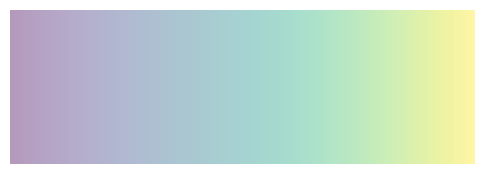

In [10]:
def lighten_cmap(cmap, factor=0.3):
    cmap = plt.cm.get_cmap(cmap, 256)  # Get the original colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Blend each color with white by adjusting RGB values
    white = np.array([1, 1, 1, 1])  # RGBA for white
    new_colors = (1 - factor) * colors + factor * white

    return LinearSegmentedColormap.from_list('lighter_' + cmap.name, new_colors)


def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()
    plt.show()


# Custom colormap: viridis with white added
viridis = plt.cm.get_cmap('viridis', 256)
new_colors = viridis(np.linspace(0, 1, 256))

# Modify the first 30% of the colormap to blend with white
new_colors[:50, :] = [1, 1, 1, 1]  # Setting white for the first 50 values
custom_cmap = LinearSegmentedColormap.from_list('viridis_white', new_colors)

# Generate a lighter version of viridis
lighter_viridis = lighten_cmap('viridis', factor=0.6)  # factor closer to 1 means lighter

# Visualize the lighter viridis colormap
plot_colormap(lighter_viridis)

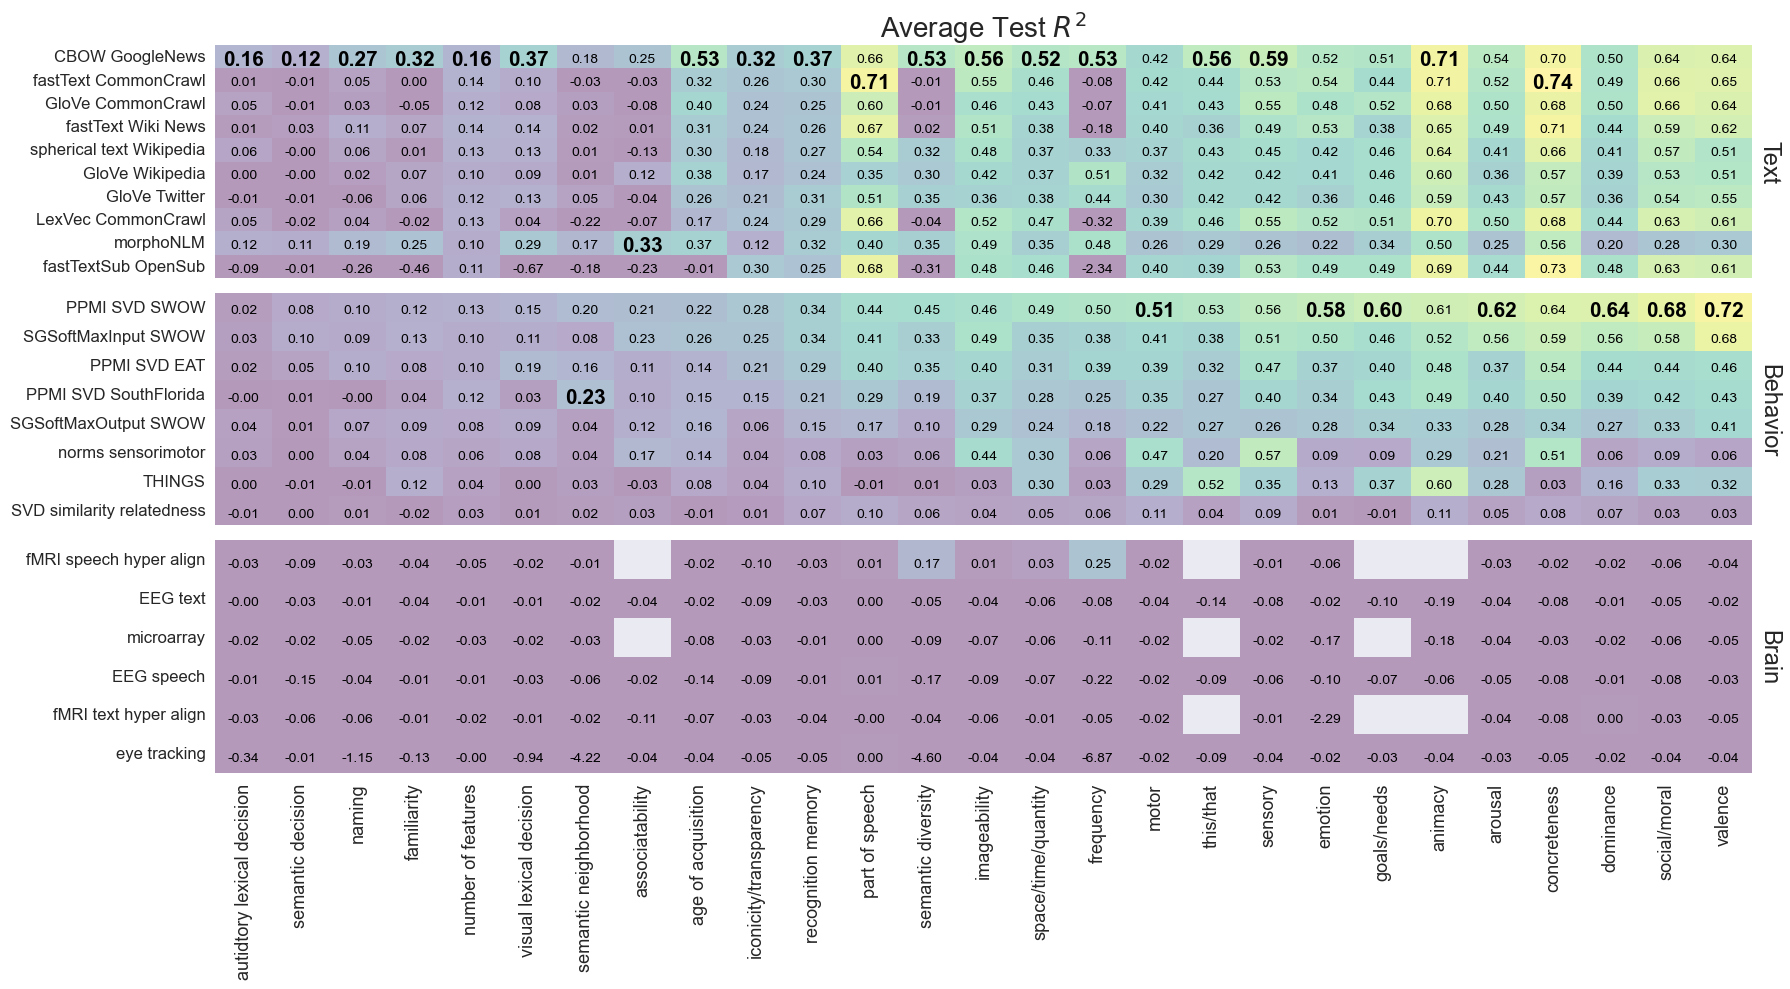

In [11]:
def annotate(heat_df, ax):
    for x, norm_cat in enumerate(heat_df.columns):
        for y, embed in enumerate(heat_df.index):
            annot = heat_df.loc[embed, norm_cat]
            
            # Scientific notation
            if abs(annot) > 1e3:
                annot = f'{annot:.1e}'
            elif np.isnan(annot):
                annot = ''
            else:
                annot = f'{annot:.2f}'
            
            # Fontsize and fontweight
            if winner_mask.loc[embed, norm_cat]:
                fontsize, fontweight = 15, 'bold'
            else:
                fontsize, fontweight = 10, 'normal'
            
            
            ax.text(
                x + .5, y + .6, annot, fontsize=fontsize, fontweight=fontweight,
                ha='center', va='center', color='black'
            )

top_behav = (
    rca_avg[[embed_to_type[embed] == 'behavior' for embed in rca_avg.index]] # Selects behavior embeds
    .mean(axis=1).idxmax() # Selects the behavior embed with the highest average r2
)

# Sorts norms by the average r2 of the top behavior embed
norm_ord = rca_avg.loc[top_behav].sort_values(ascending=True).index

# Builds heatmap dfs
heat_dfs = {}
embed_types = ['text', 'brain', 'behavior']
for embed_type in embed_types:
    heat_df = rca_avg[[embed_to_type[embed] == embed_type for embed in rca_avg.index]]

    # Sorts index and columns
    embed_order = heat_df.mean(axis=1).sort_values(ascending=False).index
    heat_dfs[embed_type] = heat_df[norm_ord].loc[embed_order]

fig, axs = plt.subplots(3, 1, figsize=(18, 10))

vmax = rca_avg.max().max()
for i, embed_type in enumerate(['text', 'behavior', 'brain']):
    heat_df = heat_dfs[embed_type]
    
    sns.heatmap(
        heat_df, ax=axs[i], vmin=0, cmap=lighter_viridis, 
        vmax=vmax, annot=False, fmt='', cbar=False,
        
    )
    
    
    axs[i].set(xlabel='', xticklabels=[])
    
    # sets ylabel on right-hand side and flips it
    axs[i].set_ylabel(
        embed_type.title(), fontsize=17, rotation=270,
        labelpad=20, va='center', ha='center'
    )
    axs[i].yaxis.set_label_position('right')
    
    # Annotates cells
    annotate(heat_df, axs[i])
    
    
    # Ensure y-axis labels match the number of ticks
    axs[i].set_yticks(pd.Series(range(len(heat_df.index))) + .5)
    heat_df.index = heat_df.index.str.replace('SVD_sim_rel', 'SVD_similarity_relatedness')
    heat_df.index = heat_df.index.str.replace('_', ' ', regex=True)
    axs[i].set_yticklabels(heat_df.index, fontsize=12)


# Adding xticklabels to last plot
axs[-1].set_xticklabels(norm_ord, rotation=90, fontsize=13)

# Sets figure title
axs[0].set_title('Average Test ${R^2}$', fontsize=20)
    
fig.tight_layout()
plt.savefig('../../figures/rca.png', dpi=300, bbox_inches='tight')